# Import Libraries

In [37]:
import math
import random
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt

import pickle
from functools import partial, update_wrapper

def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, make_scorer, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Result storage

In [38]:
results_overview = {}
predictions_per_model = {}

# Data Loading

In [39]:
df_data_train = pd.read_csv('./Data/amazon_review_ID.shuf.lrn.csv', low_memory=False, sep=',')
df_data_test = pd.read_csv('./Data/amazon_review_ID.shuf.tes.csv', low_memory=False, sep=',')

In [40]:
df_data_train.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000,Class
0,0,8,6,10,6,7,2,2,2,3,...,1,0,0,0,0,0,0,0,0,Chell
1,1,13,1,13,9,8,8,2,3,2,...,4,1,2,1,0,1,0,0,0,Engineer
2,2,16,7,6,7,9,3,4,2,6,...,0,0,0,0,1,0,0,0,0,Grove
3,3,8,11,10,11,3,7,0,4,2,...,0,0,1,0,0,0,2,1,0,Davisson
4,4,10,11,8,5,3,4,2,5,5,...,0,0,0,0,0,0,0,0,0,Wilson


## Class Distribution

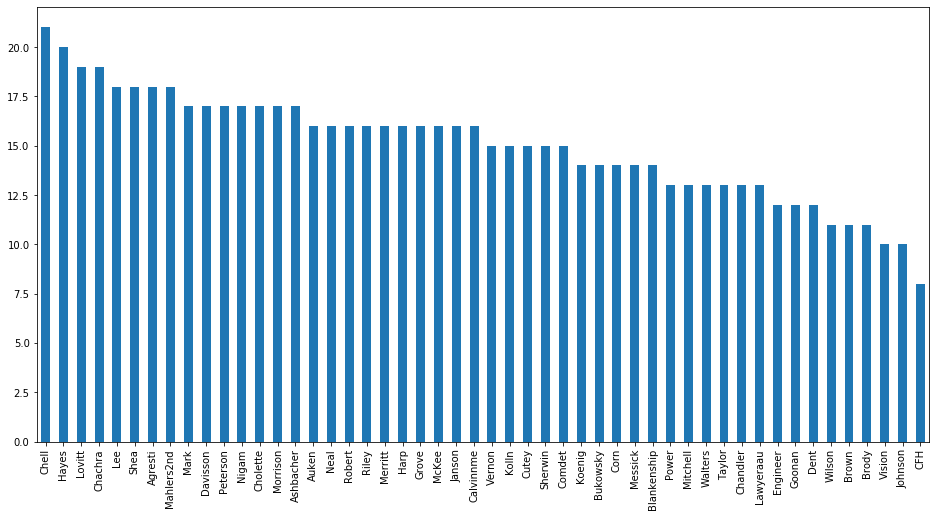

Chell          21
Hayes          20
Lovitt         19
Chachra        19
Lee            18
Shea           18
Agresti        18
Mahlers2nd     18
Mark           17
Davisson       17
Peterson       17
Nigam          17
Cholette       17
Morrison       17
Ashbacher      17
Auken          16
Neal           16
Robert         16
Riley          16
Merritt        16
Harp           16
Grove          16
McKee          16
Janson         16
Calvinnme      16
Vernon         15
Kolln          15
Cutey          15
Sherwin        15
Comdet         15
Koenig         14
Bukowsky       14
Corn           14
Messick        14
Blankenship    14
Power          13
Mitchell       13
Walters        13
Taylor         13
Chandler       13
Lawyeraau      13
Engineer       12
Goonan         12
Dent           12
Wilson         11
Brown          11
Brody          11
Vision         10
Johnson        10
CFH             8
Name: Class, dtype: int64

50

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
df_data_train['Class'].value_counts().plot(kind='bar')
plt.show()

display(df_data_train['Class'].value_counts())
display(len(df_data_train['Class'].value_counts()))

## Data Preprocessing

In [42]:
df_train = df_data_train.copy()

#Factorize the classes
class_factor = df_data_train['Class'].factorize()
class_index = class_factor[1]
df_train['ClassF'] = class_factor[0]

#Feature columns
columns = sorted(set(df_data_train.columns) - set(['ID', 'Class', 'ClassF']))

#Create feature matrix
X = df_train[columns].to_numpy()

#Create target vector
Y = df_train['ClassF'].to_numpy()

#Create test matrix
X_test = df_data_test[columns]

## TDIF Transformation

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X)
X_test_tfidf = tfidf.transform(X_test)


tf = TfidfTransformer(use_idf=False)
X_tf = tf.fit_transform(X)
X_test_tf = tf.fit_transform(X_test)

In [44]:
pd.DataFrame(X_test_tfidf.A).head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.045764,0.003592,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.008537,0.008849,0.0,0.0,0.000000,0.000000,0.000000
1,0.026166,0.011552,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.036819,0.000000,0.000000,0.0,0.0,0.000000,0.018518,0.008549
2,0.039805,0.002604,0.0,0.0,0.006336,0.0,0.0,0.0,0.01042,0.0,...,0.0,0.0,0.000000,0.006188,0.000000,0.0,0.0,0.005918,0.000000,0.000000
3,0.024218,0.014257,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.022720,0.000000,0.000000,0.0,0.0,0.000000,0.011427,0.000000
4,0.022513,0.011780,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.007082,0.000000


# Linear Model

In [13]:
#do not run again
'''
clf = LogisticRegression()

parameter_grid = {
    'penalty': ['l2', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 200,250]
}
cv_grid = GridSearchCV(clf, parameter_grid, cv=3, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit='accuracy')
cv_grid.fit(X_tfidf, Y)

print("Best Parameter Choice:")
print(cv_grid.best_params_)
'''

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 21.0min finished


Best Parameter Choice:
{'max_iter': 250, 'penalty': 'none', 'solver': 'sag'}


C:\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Linear Model: Results overview

In [21]:
#do not run again
'''
selected_columns = [
    'param_penalty',
    'param_solver',
    'param_max_iter',
    'mean_test_accuracy',
    'mean_test_balanced_accuracy',
    'mean_test_f1_weighted',
    'mean_fit_time'
]
df_result = pd.DataFrame(cv_grid.cv_results_).sort_values(by='mean_test_accuracy', ascending=False).head(10)[selected_columns]
df_result = df_result.rename(columns={
    'param_estimator_penalty': "penalty",
    'param_estimator_solver': "solver",
    'param_estimator_max_iter': "max_iter",
    "mean_test_accuracy": "accuracy",
    "mean_test_balanced_accuracy": "balanced_accuracy",
    "mean_test_f1_weighted": "f1_weighted",
    "mean_fit_time": "fit_time"
})


for col in df_result.columns:
    if df_result[col].dtype == np.float64:
        df_result[col] = df_result[col].apply(lambda x: '{0:.3f}'.format(round(x,3)))
df_result
'''

,param_penalty,param_solver,param_max_iter,accuracy,balanced_accuracy,f1_weighted,fit_time
38,none,sag,250,0.676,0.666,0.667,140.842
28,none,sag,200,0.675,0.664,0.664,111.913
18,none,sag,100,0.672,0.661,0.662,59.872
39,none,saga,250,0.671,0.660,0.661,163.624
25,none,newton-cg,200,0.671,0.663,0.660,1.610
35,none,newton-cg,250,0.671,0.663,0.660,1.636
15,none,newton-cg,100,0.671,0.663,0.660,1.586
5,none,newton-cg,50,0.671,0.663,0.660,1.599
19,none,saga,100,0.668,0.657,0.659,74.250
29,none,saga,200,0.665,0.654,0.656,142.532


# Linear Model: Prediction

In [45]:
clf = make_pipeline( LogisticRegression(max_iter= 250, penalty = 'none', solver = 'sag' ))
clf.fit(X_tfidf, Y)

# CV
cv_result = cross_validate(clf, X_tfidf, Y, cv=3, scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)

results_overview['Linear Model'] = {
    'accuracy': cv_result['test_accuracy'].mean(),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'fit_time' : cv_result['fit_time'].mean()
    }

display(results_overview)

# Predict
y_prediction = clf.predict(X_test)

C:\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'Linear Model': {'accuracy': 0.6786666666666666,
  'balanced_accuracy': 0.6694603174603175,
  'f1_weighted': 0.670509991533521,
  'fit_time': 117.83462317784627}}

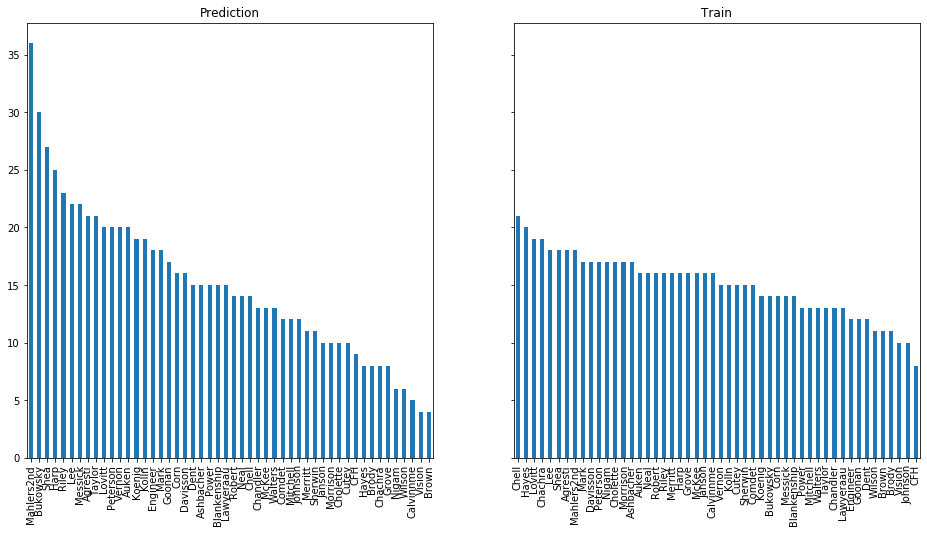

In [53]:
df_solution_test = pd.DataFrame(df_data_test['ID'])
df_solution_test['Class'] = [class_index[p] for p in y_prediction]
df_solution_test = df_solution_test.set_index('ID')

# Class distribution
fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_size_inches(16, 8)

df_solution_test['Class'].value_counts().plot(kind='bar', ax = axs[0])
axs[0].set_title("Prediction")

df_data_train['Class'].value_counts().plot(kind='bar', ax = axs[1])
axs[1].set_title("Train")

plt.show()

# Random Forest

In [66]:
#do not run again
'''
clf = OneVsRestClassifier(RandomForestClassifier())

parameter_grid = {
    'estimator__n_estimators': [10, 50, 100, 250],
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [None, 20, 30, 50]
}
cv_grid = GridSearchCV(clf, parameter_grid, cv=5, verbose=10, n_jobs=-1, scoring=['accuracy', 'balanced_accuracy', 'f1_weighted'], refit='accuracy')
cv_grid.fit(X_tfidf, Y)

print(cv_grid.best_params_)
'''

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 36.9min finished


{'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__n_estimators': 250}


# Random Forest: result overview

In [67]:
#do not run again
'''
selected_columns = [
    'param_estimator__n_estimators',
    'param_estimator__max_depth',
    'param_estimator__criterion',
    'mean_test_accuracy',
    'mean_test_balanced_accuracy',
    'mean_test_f1_weighted',
    'mean_fit_time'
]
df_result = pd.DataFrame(cv_grid.cv_results_).sort_values(by='mean_test_accuracy', ascending=False).head(10)[selected_columns]
df_result = df_result.rename(columns={
    'param_estimator__n_estimators': "n_estimators",
    'param_estimator__max_depth': "max_depth",
    'param_estimator__criterion': "criterion",
    "mean_test_accuracy": "accuracy",
    "mean_test_balanced_accuracy": "balanced_accuracy",
    "mean_test_f1_weighted": "f1_weighted",
    "mean_fit_time": "fit_time"
})

for col in df_result.columns:
    if df_result[col].dtype == np.float64:
        df_result[col] = df_result[col].apply(lambda x: '{0:.3f}'.format(round(x,3)))
df_result
'''

,n_estimators,max_depth,criterion,accuracy,balanced_accuracy,f1_weighted,fit_time
19,250,None,entropy,0.621,0.621,0.595,122.383
27,250,30,entropy,0.616,0.613,0.591,124.055
23,250,20,entropy,0.605,0.603,0.580,122.805
31,250,50,entropy,0.596,0.589,0.563,112.706
18,100,None,entropy,0.541,0.540,0.515,47.237
26,100,30,entropy,0.540,0.545,0.513,51.685
22,100,20,entropy,0.536,0.532,0.512,54.657
30,100,50,entropy,0.523,0.522,0.494,49.217
15,250,50,gini,0.512,0.512,0.483,116.734
3,250,None,gini,0.501,0.500,0.480,111.097


# Random Forest: Prediction

In [68]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=250, max_depth=None, criterion='entropy'))
clf.fit(X_tfidf, Y)

# CV
cv_result = cross_validate(clf, X_tfidf, Y, cv=3, scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted'], n_jobs=-1)

results_overview['Random Forest'] = {
    'accuracy': cv_result['test_accuracy'].mean(),
    'balanced_accuracy': cv_result['test_balanced_accuracy'].mean(),
    'f1_weighted': cv_result['test_f1_weighted'].mean(),
    'fit_time' : cv_result['fit_time'].mean()
    }

display(results_overview)

# Predict
y_prediction = clf.predict(X_test)

{'Linear Model': {'accuracy': 0.6786666666666666,
  'balanced_accuracy': 0.6694603174603175,
  'f1_weighted': 0.670509991533521,
  'fit_time': 117.83462317784627},
 'Random Forest': {'accuracy': 0.572,
  'balanced_accuracy': 0.5656190476190476,
  'f1_weighted': 0.5491334572433643,
  'fit_time': 78.73584826787312}}

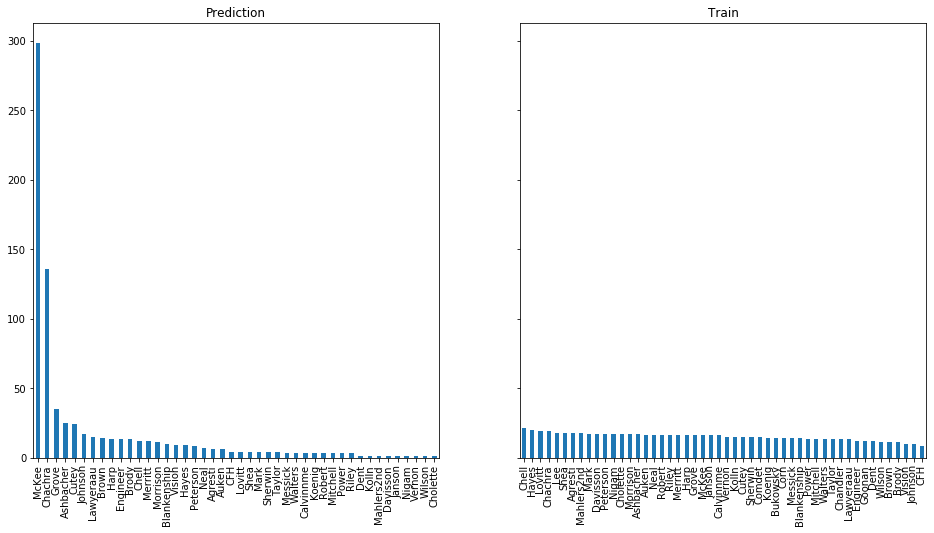

In [69]:
df_solution_test = pd.DataFrame(df_data_test['ID'])
df_solution_test['Class'] = [class_index[p] for p in y_prediction]
df_solution_test = df_solution_test.set_index('ID')

# Class distribution
fig, axs = plt.subplots(1, 2, sharey = True)
fig.set_size_inches(16, 8)

df_solution_test['Class'].value_counts().plot(kind='bar', ax = axs[0])
axs[0].set_title("Prediction")

df_data_train['Class'].value_counts().plot(kind='bar', ax = axs[1])
axs[1].set_title("Train")

plt.show()